# Dino Fun World Data Analysis
### Directions

The database provided by the park administration is formatted to be readable by any SQL database library. The course staff recommends the sqlite3 library. The database contains three tables, named 'checkin', 'attractions', and 'sequences'. The database file is named 'dinofunworld.db'. 

The information contained in each of these tables is listed below:

`checkin`:
    - The check-in data for all visitors for the day in the park. The data includes two types of check-ins: inferred and actual checkins.
    - Fields: visitorID, timestamp, attraction, duration, type
`attraction`:
    - The attractions in the park by their corresponding AttractionID, Name, Region, Category, and type. Regions are from the VAST Challenge map such as Coaster Alley, Tundra Land, etc. Categories include Thrill rides, Kiddie Rides, etc. Type is broken into Outdoor Coaster, Other Ride, Carousel, etc.
    - Fields: AttractionID, Name, Region, Category, type
`sequences`:
    - The check-in sequences of visitors. These sequences list the position of each visitor to the park every five minutes. If the visitor has not entered the part yet, the sequence has a value of 0 for that time interval. If the visitor is in the park, the sequence lists the attraction they have most recently checked in to until they check in to a new one or leave the park.
    - Fields: visitorID, sequence

Using the provided data, answer the four questions that the administrators have asked. Must create a SQL query for to answer each question.

## Part 1
### Description

The administrators of a small amusement park in your hometown has ask a few questions about their park operations. The dataset that they provided for you to perform the requested analysis includes the movement and communication data captured from the park attendees' apps during one weekend (Friday, Saturday, and Sunday).

The administrators would like you to answer four relatively simple questions about the park activities on the day in question. These questions all deal with park operations and can be answered using the data provided.

Question 1: What is the most popular attraction to visit in the park?

Question 2: What ride (note that not all attractions are rides) has the longest average visit time?

Question 3: Which Fast Food offering has the fewest visitors?

Question 4: Compute the Skyline of number of visits and visit time for the park's ride, and report the rides that appear in the Skyline. (Note: Your answer should be three points, which can be given in any order.)

In [16]:
import sqlite3
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.vq import whiten
from pandas.plotting import parallel_coordinates
from scipy.cluster.hierarchy import linkage, dendrogram

warnings.filterwarnings("ignore")
# Connect to the database and create a cursor object
conn = sqlite3.connect('dinofunworld.db')
cur = conn.cursor()

# Function a list argument and print one item per row
def print_rows(rows, limit=-1):
    for row in rows[:limit]:
        print(row)

tables = ['checkin', 'attraction', 'sequences']
# Statement to retrieve the first 3 rows from the db
table_stm = '''SELECT * FROM {} LIMIT 3;'''
# Quick glance to the data tables
for table in tables:
    print('Table:', table)
    cur.execute(table_stm.format(table))
    print_rows(cur.fetchall())
    print()

Table: checkin
(0, 436, '2014-06-08 09:48:51', 83, '0:00:59', 'actual')
(1, 436, '2014-06-08 09:56:46', 42, '0:08:03', 'inferred')

Table: attraction
(0, 1, 'Wrightiraptor Mountain', 'Coaster Alley', 'Thrill Rides\r', 'Outdoor Coaster')
(1, 2, 'Galactosaurus Rage', 'Coaster Alley', 'Thrill Rides\r', 'Outdoor Coaster')

Table: sequences
(0, 436, '0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-

In [2]:
# Question 1: What is the most popular attraction to visit in the park?
# Notes: Your output should be the name of the attraction.

most_popular_stm = '''
SELECT name
FROM attraction
WHERE attractionid = (SELECT attraction
    FROM checkin
    GROUP BY attraction
    ORDER BY COUNT(*)
    DESC LIMIT 1);
'''


cur.execute(most_popular_stm)
most_popular_attraction = cur.fetchone()[0]
print('The most popular attraction to visit in the park: ', most_popular_attraction)

The most popular attraction to visit in the park:  Atmosfear


In [3]:
# Question 2: What ride (note that not all attractions are rides) has the second longest average visit time?
# Notes: Your output should be the name of the ride.

stm = '''
SELECT A.name
FROM checkin as C
INNER JOIN (SELECT distinct attractionid, name
    FROM attraction WHERE category like '%Ride%') as A
WHERE C.attraction = A.attractionid
GROUP BY C.attraction
ORDER BY avg(strftime('%s', substr('0' || duration, -8)) - strftime('%s', '00:00:00')) DESC
LIMIT 2
'''

cur.execute(stm)
ride = cur.fetchall()[1][0]
print(ride, ' has the second longest average visit time')

Flight of the Swingodon  has the second longest average visit time


In [4]:
# Question 3: Which Fast Food offering in the park has the fewest visitors?
# Notes: Your output should be the name of the fast food offering.

stm = '''
SELECT A.name
FROM checkin as C
INNER JOIN attraction as A
    ON C.attraction = A.attractionID
WHERE A.type = 'Fast Food'
GROUP BY C.attraction
ORDER BY COUNT(*)
LIMIT 1
'''

cur.execute(stm)
fast_food_name = cur.fetchone()[0]
print(fast_food_name, ' has the fewest visitors')

Theresaur Food Stop  has the fewest visitors


In [5]:
# Question 4: Compute the Skyline of number of visits and visit time for the park's ride and
#  report the rides that appear in the Skyline.
# Notes: Remember that in this case, higher visits is better and lower visit times are better.
#  Your output should be formatted as an array listing the names of the rides in the Skyline.

# Retrieve the attraction's name, the average time visitors spend at each attraction, and the number of visits
stm = '''
SELECT A.name,
    count(*) as visits,
    avg(strftime('%s', substr('0' || C.duration, -8)) - strftime('%s', '00:00:00'))/60 as avg_time
FROM checkin as C
INNER JOIN attraction as A
    ON C.attraction = A.attractionID
WHERE A.category LIKE '%Ride%'
GROUP BY A.name
HAVING visits != 0 AND avg_time IS NOT NULL
ORDER by avg_time, visits;
'''

# Will check if point1 dominates point2
def dominate(point1: list, point2: list) -> bool:
    # Check if point1 is good in all dimesions
    good_in_all_dim = point1[0] >= point2[0] and point1[1] <= point2[1]
    # Check if point 1 if better at least in one dimension
    better_at_any_point = point1[0] > point2[0] or point1[1] < point2[1]
    
    return good_in_all_dim and better_at_any_point

cur.execute(stm)
rows = cur.fetchall()

points = [row[1:] for row in rows]
# skyline_points = get_skyline(points)
skyline_points = list()


for row in rows:
    point = (row[1], row[2])
    # Check if any point from the set of points dominates a given point
    if not any(dominate(p, point) for p in points if p != point):
        skyline_points.append(row)

rides_in_skyline = list(zip(*skyline_points))[0]
print('The rides that appear in the Skyline: ' +  ', '.join(rides_in_skyline))


The rides that appear in the Skyline: Dykesadactyl Thrill, Wrightiraptor Mountain, Galactosaurus Rage, Keimosaurus Big Spin, Atmosfear


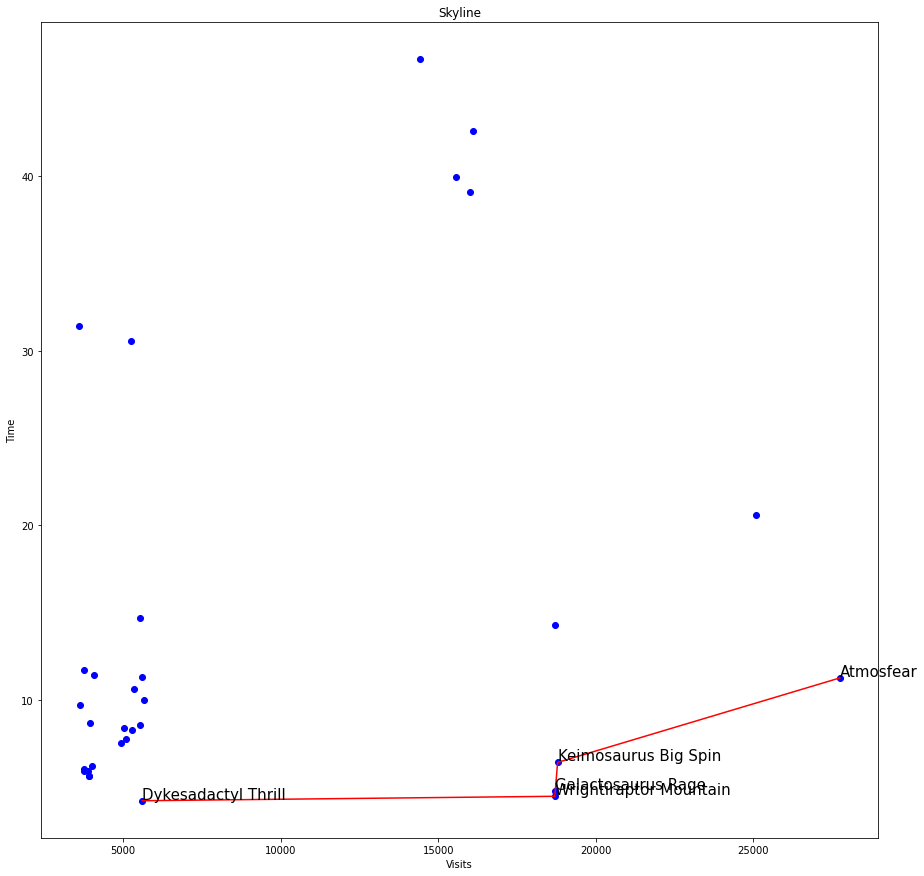

In [6]:
# Time Visit vs Visit Graph 
# SKYLINE

fig = plt.figure(figsize=(15,15))
plt.xlabel('Visits')
plt.ylabel('Time')
plt.title('Skyline')

plt.scatter(*zip(*points), c='b')
for name, x, y in skyline_points:
#     plt.scatter(row[1], row[2], c='b')
    plt.text(x+0.1, y+0.1, name, fontsize=15)

plt.plot(*list(zip(*skyline_points))[1:], c='r')
plt.show()


## Part 2: Graphing
### Description

Impressed by your previous work, the administrators of Dino Fun World have asked you to create some charts that they can use in their next presentation to upper management.

The administrators would like you to create four graphs:

Chart 1: A pie chart depicting visits to thrill ride attractions.

Chart 2: A bar chart depicting total visits to food stalls.

* Please query attractions with Category equal to "Food".

Chart 3: A line chart depicting attendance at the newest ride, Atmosfear over the course of the day.

* For this question, use data from the table "sequences". You can assume that all activity sequences are aligned by time (i.e., the first node of all sequences occurred at the same time) and are of the same length.

* You only need to consider the first 16 hours of records in the sequences, which is considered the open hours of the park in one day. Specifically, because an activity sequence from the "sequences" table was updated/recorded every 5 minutes, you need to extract the first 192 items (16h * 60m / 5m = 192).

* Your data list (which will be printed) must be in the format of tuple list (or list of lists). The first item in tuples is irrelevant, but you can put in some meaningful information. The second item is the count of visits at that moment. For example, your output should look like this (in Python syntax; not relevant to the correct answer): [ (0, 0), (1, 7), (2, 3), …, (190, 4), (191, 5) ].

Chart 4: A box-and-whisker plot depicting total visits to the park's Kiddie Rides.

* The to-be-printed, the  data list must be ordered by AttractionID (a field in the table "attraction").

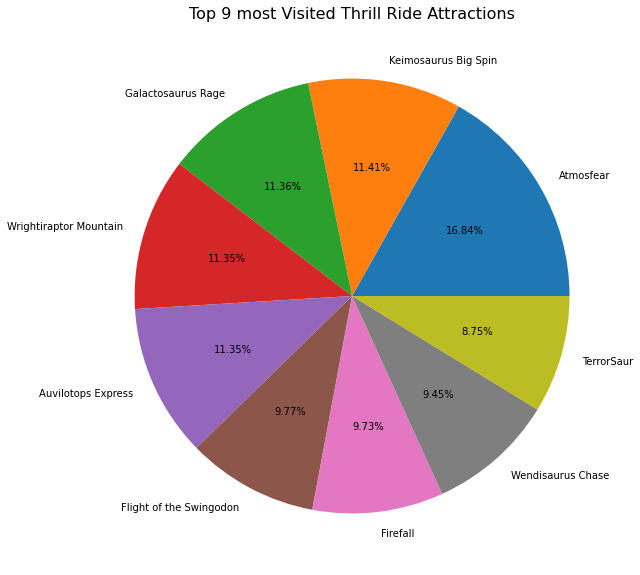

[('Atmosfear', 27747), ('Keimosaurus Big Spin', 18792), ('Galactosaurus Rage', 18717), ('Wrightiraptor Mountain', 18700), ('Auvilotops Express', 18694), ('Flight of the Swingodon', 16093), ('Firefall', 16024), ('Wendisaurus Chase', 15577), ('TerrorSaur', 14415)]


In [7]:
# Chart 1: A pie chart depicting visits to thrill ride attractions.
# Make a Pie Chart of the visits to Thrill Ride attractions. For this question,
#  display the pie chart in the notebook and print the data used to create the
#  pie chart as a list of lists (ex: [['Ride 1', 10], ['Ride 2', 100], ...])

stm = '''
SELECT A.name, COUNT(*) as visits
FROM checkin as C
INNER JOIN attraction as A
ON C.attraction = A.attractionid
WHERE A.category = 'Thrill Rides\r'
GROUP BY C.attraction
ORDER BY visits DESC;
'''

# Pie charts with maximum of 7 to 9 categories are best for human perception. 
cur.execute(stm)
rows = cur.fetchall()

# retrieve attractions and visits and store them in two different lists
attractions = list(zip(*rows))[0]
visits = list(zip(*rows))[1]

fig = plt.figure(figsize=(15, 10))
plt.pie(visits, labels=attractions, autopct='%1.2f%%', shadow=False)
plt.title('Top 9 most Visited Thrill Ride Attractions', fontsize=16)

plt.show()

print(rows)


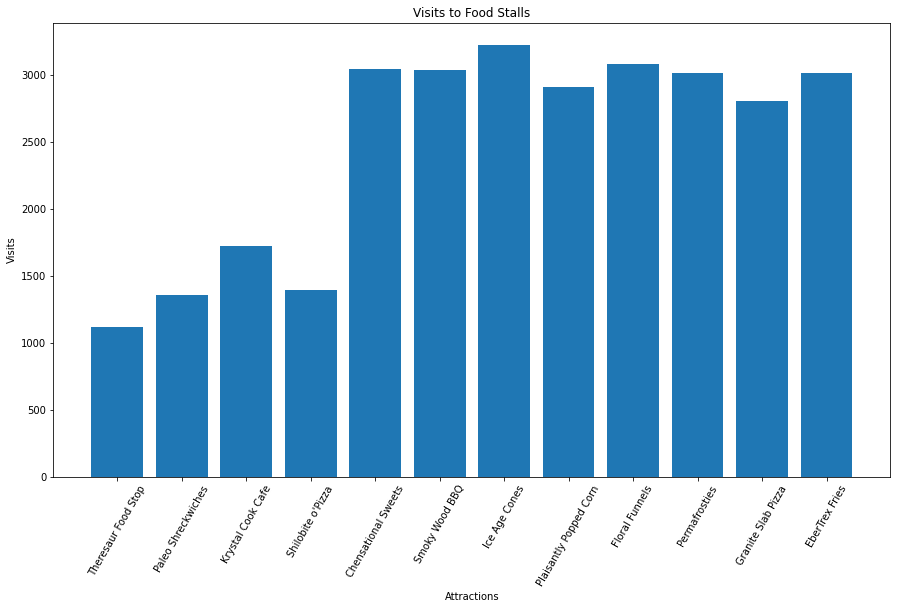

[('Theresaur Food Stop', 1116), ('Paleo Shreckwiches', 1361), ('Krystal Cook Cafe', 1725), ("Shilobite o'Pizza", 1393), ('Chensational Sweets', 3049), ('Smoky Wood BBQ', 3037), ('Ice Age Cones', 3228), ('Plaisantly Popped Corn', 2914), ('Floral Funnels', 3083), ('Permafrosties', 3018), ('Granite Slab Pizza', 2810), ('EberTrex Fries', 3018)]


In [8]:
# Chart 2: A bar chart depicting total visits to food stalls.
# Make a bar chart of total visits to food stalls. For this question,
#  display the bar chart in the notebook and print the data used to create the
#  bar chart as a list of lists (ex: [['Stall 1', 10], ['Stall 2', 50], ...])
stm = '''
SELECT A.name, COUNT(*) as visits
FROM checkin as C
INNER JOIN attraction as A
ON C.attraction = A.attractionid
WHERE A.category = 'Food\r'
GROUP BY C.attraction;'''
cur.execute(stm)
rows = cur.fetchall()

# retrieve attractions and visits and store them in two different lists
attractions = list(zip(*rows))[0]
visits = list(zip(*rows))[1]

fig = plt.figure(figsize=(15, 10))
plt.bar(attractions, visits)

x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(60)

plt.subplots_adjust(bottom=0.25)
plt.title('Visits to Food Stalls')
plt.xlabel('Attractions')
plt.ylabel('Visits')
plt.show()

print(rows)

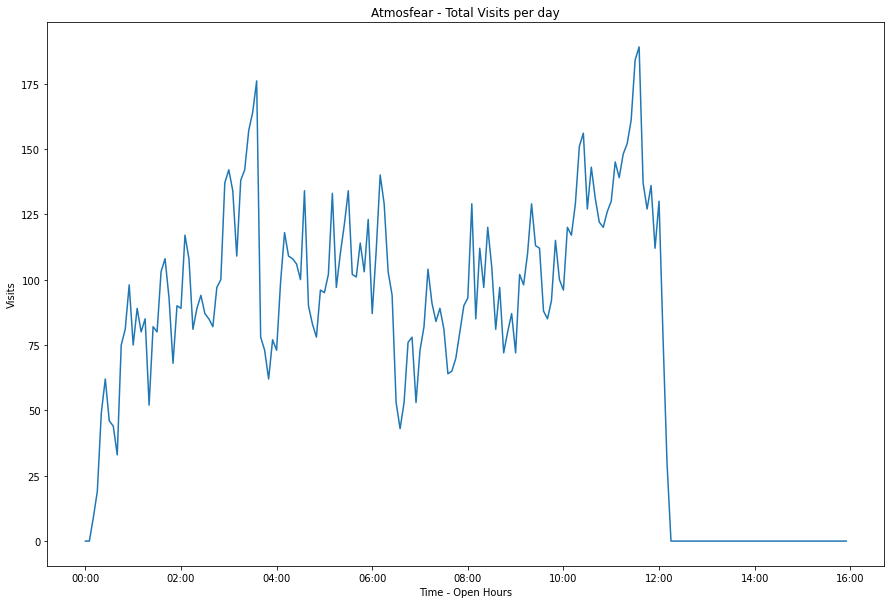

[(0, 0), (1, 0), (2, 9), (3, 19), (4, 49), (5, 62), (6, 46), (7, 44), (8, 33), (9, 75), (10, 81), (11, 98), (12, 75), (13, 89), (14, 80), (15, 85), (16, 52), (17, 82), (18, 80), (19, 103), (20, 108), (21, 93), (22, 68), (23, 90), (24, 89), (25, 117), (26, 108), (27, 81), (28, 89), (29, 94), (30, 87), (31, 85), (32, 82), (33, 97), (34, 100), (35, 137), (36, 142), (37, 134), (38, 109), (39, 138), (40, 142), (41, 157), (42, 164), (43, 176), (44, 78), (45, 73), (46, 62), (47, 77), (48, 73), (49, 99), (50, 118), (51, 109), (52, 108), (53, 106), (54, 100), (55, 134), (56, 90), (57, 83), (58, 78), (59, 96), (60, 95), (61, 102), (62, 133), (63, 97), (64, 110), (65, 121), (66, 134), (67, 102), (68, 101), (69, 114), (70, 103), (71, 123), (72, 87), (73, 111), (74, 140), (75, 129), (76, 103), (77, 94), (78, 53), (79, 43), (80, 53), (81, 76), (82, 78), (83, 53), (84, 73), (85, 82), (86, 104), (87, 91), (88, 84), (89, 89), (90, 81), (91, 64), (92, 65), (93, 70), (94, 80), (95, 90), (96, 93), (97, 12

In [9]:
# Chart 3: A line chart depicting attendance at the newest ride, Atmosfear over the course of the day.
# Make a line chart of attendance at Atmosfear every five minutes. Again,
#  display the line chart in the notebook and print the data used to create the
#  chart as a list of lists (ex: [['Stall 1', 10], ['Stall 2', 50], ...])
cur.execute('''SELECT attractionid FROM attraction WHERE name = 'Atmosfear';''')
atmosfear_id = cur.fetchone()[0]

cur.execute('''SELECT sequence FROM sequences;''')
sequences = cur.fetchall()

df = pd.DataFrame.from_records(sequences, columns=['sequences'])
sequence_df = df['sequences'].str.split('-', expand=True)
visits = (sequence_df == str(atmosfear_id)).sum()

x = range(192)
y = visits[:192]

fig = plt.figure(figsize=(15,10))
plt.plot(x, y)
plt.title('Atmosfear - Total Visits per day')
plt.xlabel('Time - Open Hours')
plt.ylabel('Visits')

ax = plt.gca().xaxis
xticks_val = list(range(0, 193, 24))
xticks_labels = ['{:02d}:00'.format(int(val/12)) for val in xticks_val]
plt.xticks(xticks_val)
ax.set_ticklabels(xticks_labels)
plt.show()

print(list(zip(x, y)))


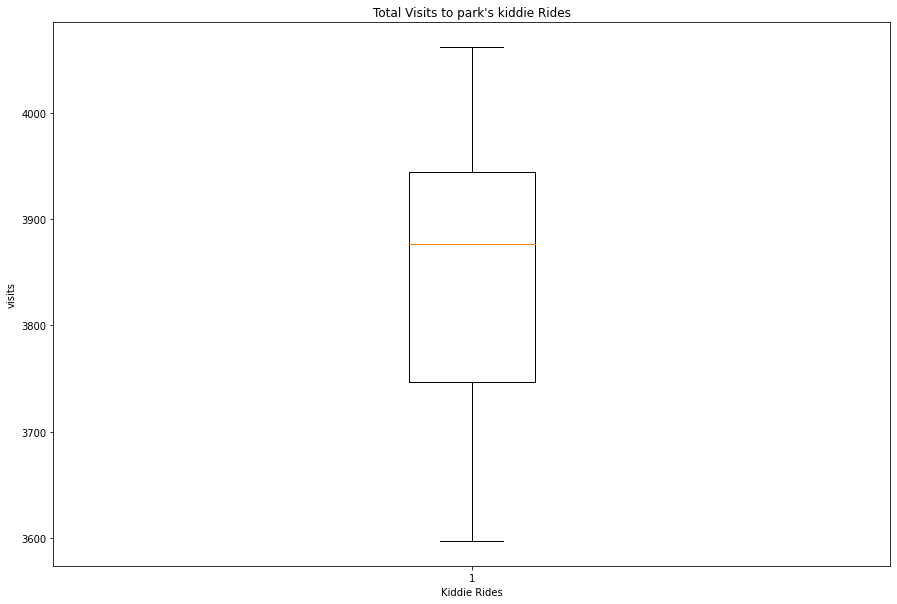

(3597, 3759, 4062, 3640, 3747, 3963, 3747, 3925, 3922, 4022, 3877)


In [10]:
# Chart 4: A box-and-whisker plot depicting total visits to the park's Kiddie Rides.
# Make a box plot of total visits to rides in the Kiddie Rides category. For
#  this question, display the box plot in the notebook and print the number of
#  visits to each ride as a list (ex: [3, 4, 5, 6, ...])

stm = '''
SELECT A.attractionid, COUNT(*) as visits
FROM checkin as C
INNER JOIN attraction as A
ON C.attraction = A.attractionid
WHERE A.category = 'Kiddie Rides\r'
GROUP BY C.attraction
ORDER BY A.attractionid;'''

cur.execute(stm)
rows = cur.fetchall()

# retrieve attractions and visits and store them in two different lists
attraction_ids = list(zip(*rows))[0]
visits = list(zip(*rows))[1]

fig = plt.figure(figsize=(15,10))
plt.boxplot(visits)
plt.title('Total Visits to park\'s kiddie Rides')
plt.xlabel('Kiddie Rides')
plt.ylabel('visits')
plt.show()

print(visits)

## Part 3: Analysis
### Assignment Description

The administrators of Dino Fun World, a local amusement park, have asked you, one of their data analysts, to perform three data analysis tasks for their park. These tasks will involve understanding, analyzing, and graphing attendance data for three days of the park's operations that the park has provided for you to use. They have provided the data in the form of a database.

Part 1: The park's administrators would like your help understanding the different paths visitors take through the park and different rides they visit. In this mission, they have selected five (5) visitors at random whose check-in sequences they would like you to analyze. For now, they would like you to construct a distance matrix for these five visitors. The five visitors have the IDs: 165316, 1835254, 296394, 404385, and 448990.

Part 2: The park's administrators would like to understand the attendance dynamics at each ride (note that not all attractions are rides). They would like to see the minimum (non-zero) attendance at each ride, the average attendance over the whole day, and the maximum attendance for each ride in a parallel coordinate plot.

Part 3: In addition to a parallel coordinate plot, the administrators would like to see a scatterplot matrix depicting the minimum, average, and maximum attendance for each ride as above.

In [11]:
# 1
# Create a distance matrix suitable for use in hierarchical clustering of the
# checkin sequences of the 5 specified visitors. Your distance function should
# count the number of dissimilarities in the sequences without considering any
# other factors. The distance matrix should be reported as a dictionary of
# dictionaries (eg. {1: {2:0, 3:0, 4:0}, 2: {1:0, 3:0, ...}, ...}).

conn = sqlite3.connect('dinofunworld.db')
cur = conn.cursor()

stm = '''
SELECT visitorid, sequence
FROM sequences
WHERE visitorid in (165316, 1835254, 296394, 404385, 448990)
ORDER BY visitorid;
'''
cur.execute(stm)
sequences = cur.fetchall()

# Nested loop to compute the distance between all 5 points
distance_matrix = dict()
for a in sequences:
    sequence_a = np.array(a[1].split('-'), dtype=int)
    distance_matrix[a[0]] = dict()
    for b in sequences:
        if a[0] != b[0]:
            sequence_b = np.array(b[1].split('-'), dtype=int)
            # Exclusive OR, XOR, return 0 only when the two inputs are equal
            # Count the number of non zero outputs
            distance = ((sequence_a ^ sequence_b) != 0).sum()
            distance_matrix[a[0]][b[0]] = distance

print(distance_matrix)

{165316: {296394: 318, 404385: 329, 448990: 318, 1835254: 336}, 296394: {165316: 318, 404385: 303, 448990: 0, 1835254: 282}, 404385: {165316: 329, 296394: 303, 448990: 303, 1835254: 298}, 448990: {165316: 318, 296394: 0, 404385: 303, 1835254: 282}, 1835254: {165316: 336, 296394: 282, 404385: 298, 448990: 282}}


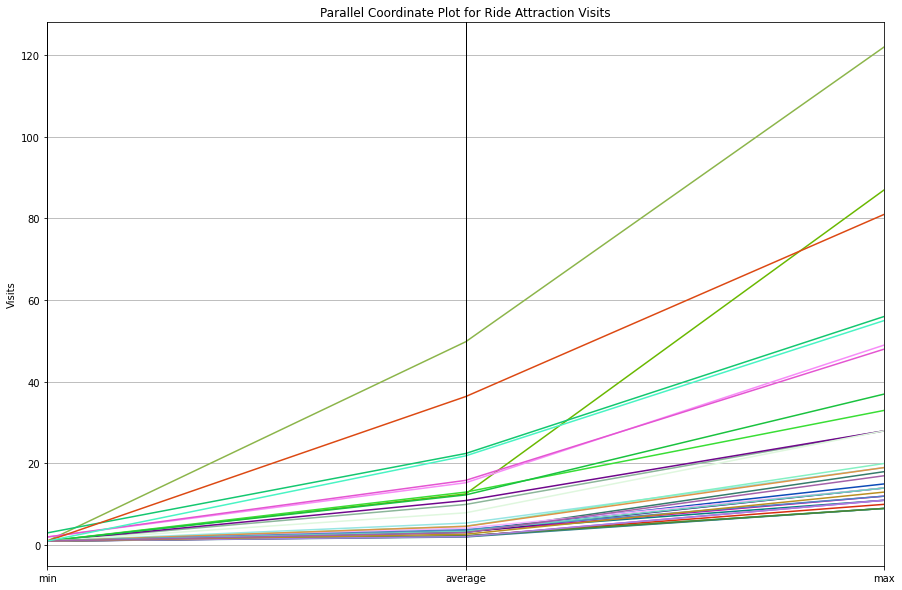

In [12]:
# 2
# Create and display a Parallel Coordinate Plot displaying the minimum, average,
# and maximum attendance for each ride in the park (note that not all attractions
# are rides).

stm = '''
SELECT attractionid, name
FROM attraction
WHERE category LIKE '%Ride%'
ORDER BY attractionid;
'''
cur.execute(stm)
ride_attractions = cur.fetchall()

stm = '''
SELECT distinct S.sequence
FROM sequences as S
INNER JOIN checkin as C
    ON S.visitorid = C.visitorid
WHERE substring(C.timestamp, 1, 10) = '2014-06-08'
;
'''
cur.execute(stm)
sequences = cur.fetchall()

df = pd.DataFrame.from_records(sequences, columns=['sequence'])
df = df['sequence'].str.split('-', expand=True)[range(192)]
df = df.astype(int)

visits = df.apply(lambda x: dict(x.value_counts()))
data = list()

for attraction in ride_attractions:
    data_dict = dict()
    attraction_id = attraction[0]

    attendance = [visit.get(attraction_id) for visit in visits if visit.get(attraction_id)]

    data_dict['attraction'] = attraction[1]
    data_dict['min'] = min(attendance)
    data_dict['average'] = sum(attendance) / 192
    data_dict['max'] = max(attendance)
    data.append(data_dict)

attraction_df = pd.DataFrame(data)

fig = plt.figure(figsize=(15,10))
parallel_coordinates(attraction_df, 'attraction')
plt.title('Parallel Coordinate Plot for Ride Attraction Visits')
plt.ylabel('Visits')
plt.gca().legend_.remove()
plt.show()

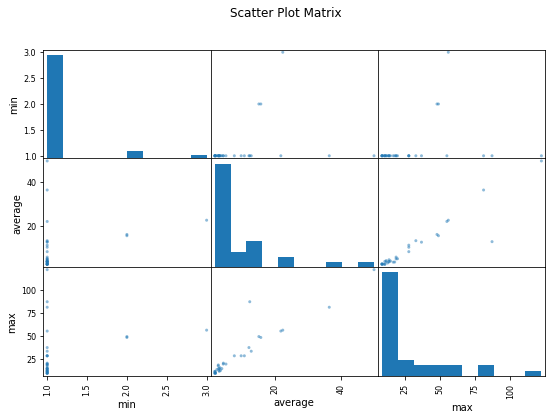

In [13]:
# 3
# Create and display a Scatterplot Matrix displaying the minimum, average, and
# maximum attendance for each ride in the park.
# Note: This is a different view into the same data as the previous part. While
# you work on these plots, consider the different things that each chart says
# about the data.

pd.plotting.scatter_matrix(attraction_df, figsize=(9, 6))
plt.suptitle('Scatter Plot Matrix')
plt.show()

## Part 4: Time Series Analysis
### Assignment Description

The administrators of Dino Fun World, a local amusement park, have asked you, one of their data analysts, to perform three data analysis tasks for the park. These tasks will involve understanding, analyzing, and graphing attendance data that the park has provided for you to use in the form of a database.

Part 1: The park's administrators are worried about the attendance at the ride 'Atmosfear' in the data window. To assuage their fears, they have asked you to create a control chart of the total attendance at this ride. Using the provided data, create a control chart displaying the attendance, mean, and standard deviation bands at one and two standard deviations.

Part 2: Some of the park's administrators are having trouble interpreting the control chart graph of 'Atmosfear' attendance, so they ask you to also provide a moving average chart of the attendance in addition to the control chart created in Part 1. In this case, they request that you use 50 samples for the size of the moving average window.

Part 3: In order to have options concerning the graphs presented, the park's administrators also ask you to provide a 50-sample moving average window with the average computed with exponential weighting (i.e., an exponentially weighted moving average) over the same 'Atmosfear' attendance data.

<IPython.core.display.Javascript object>


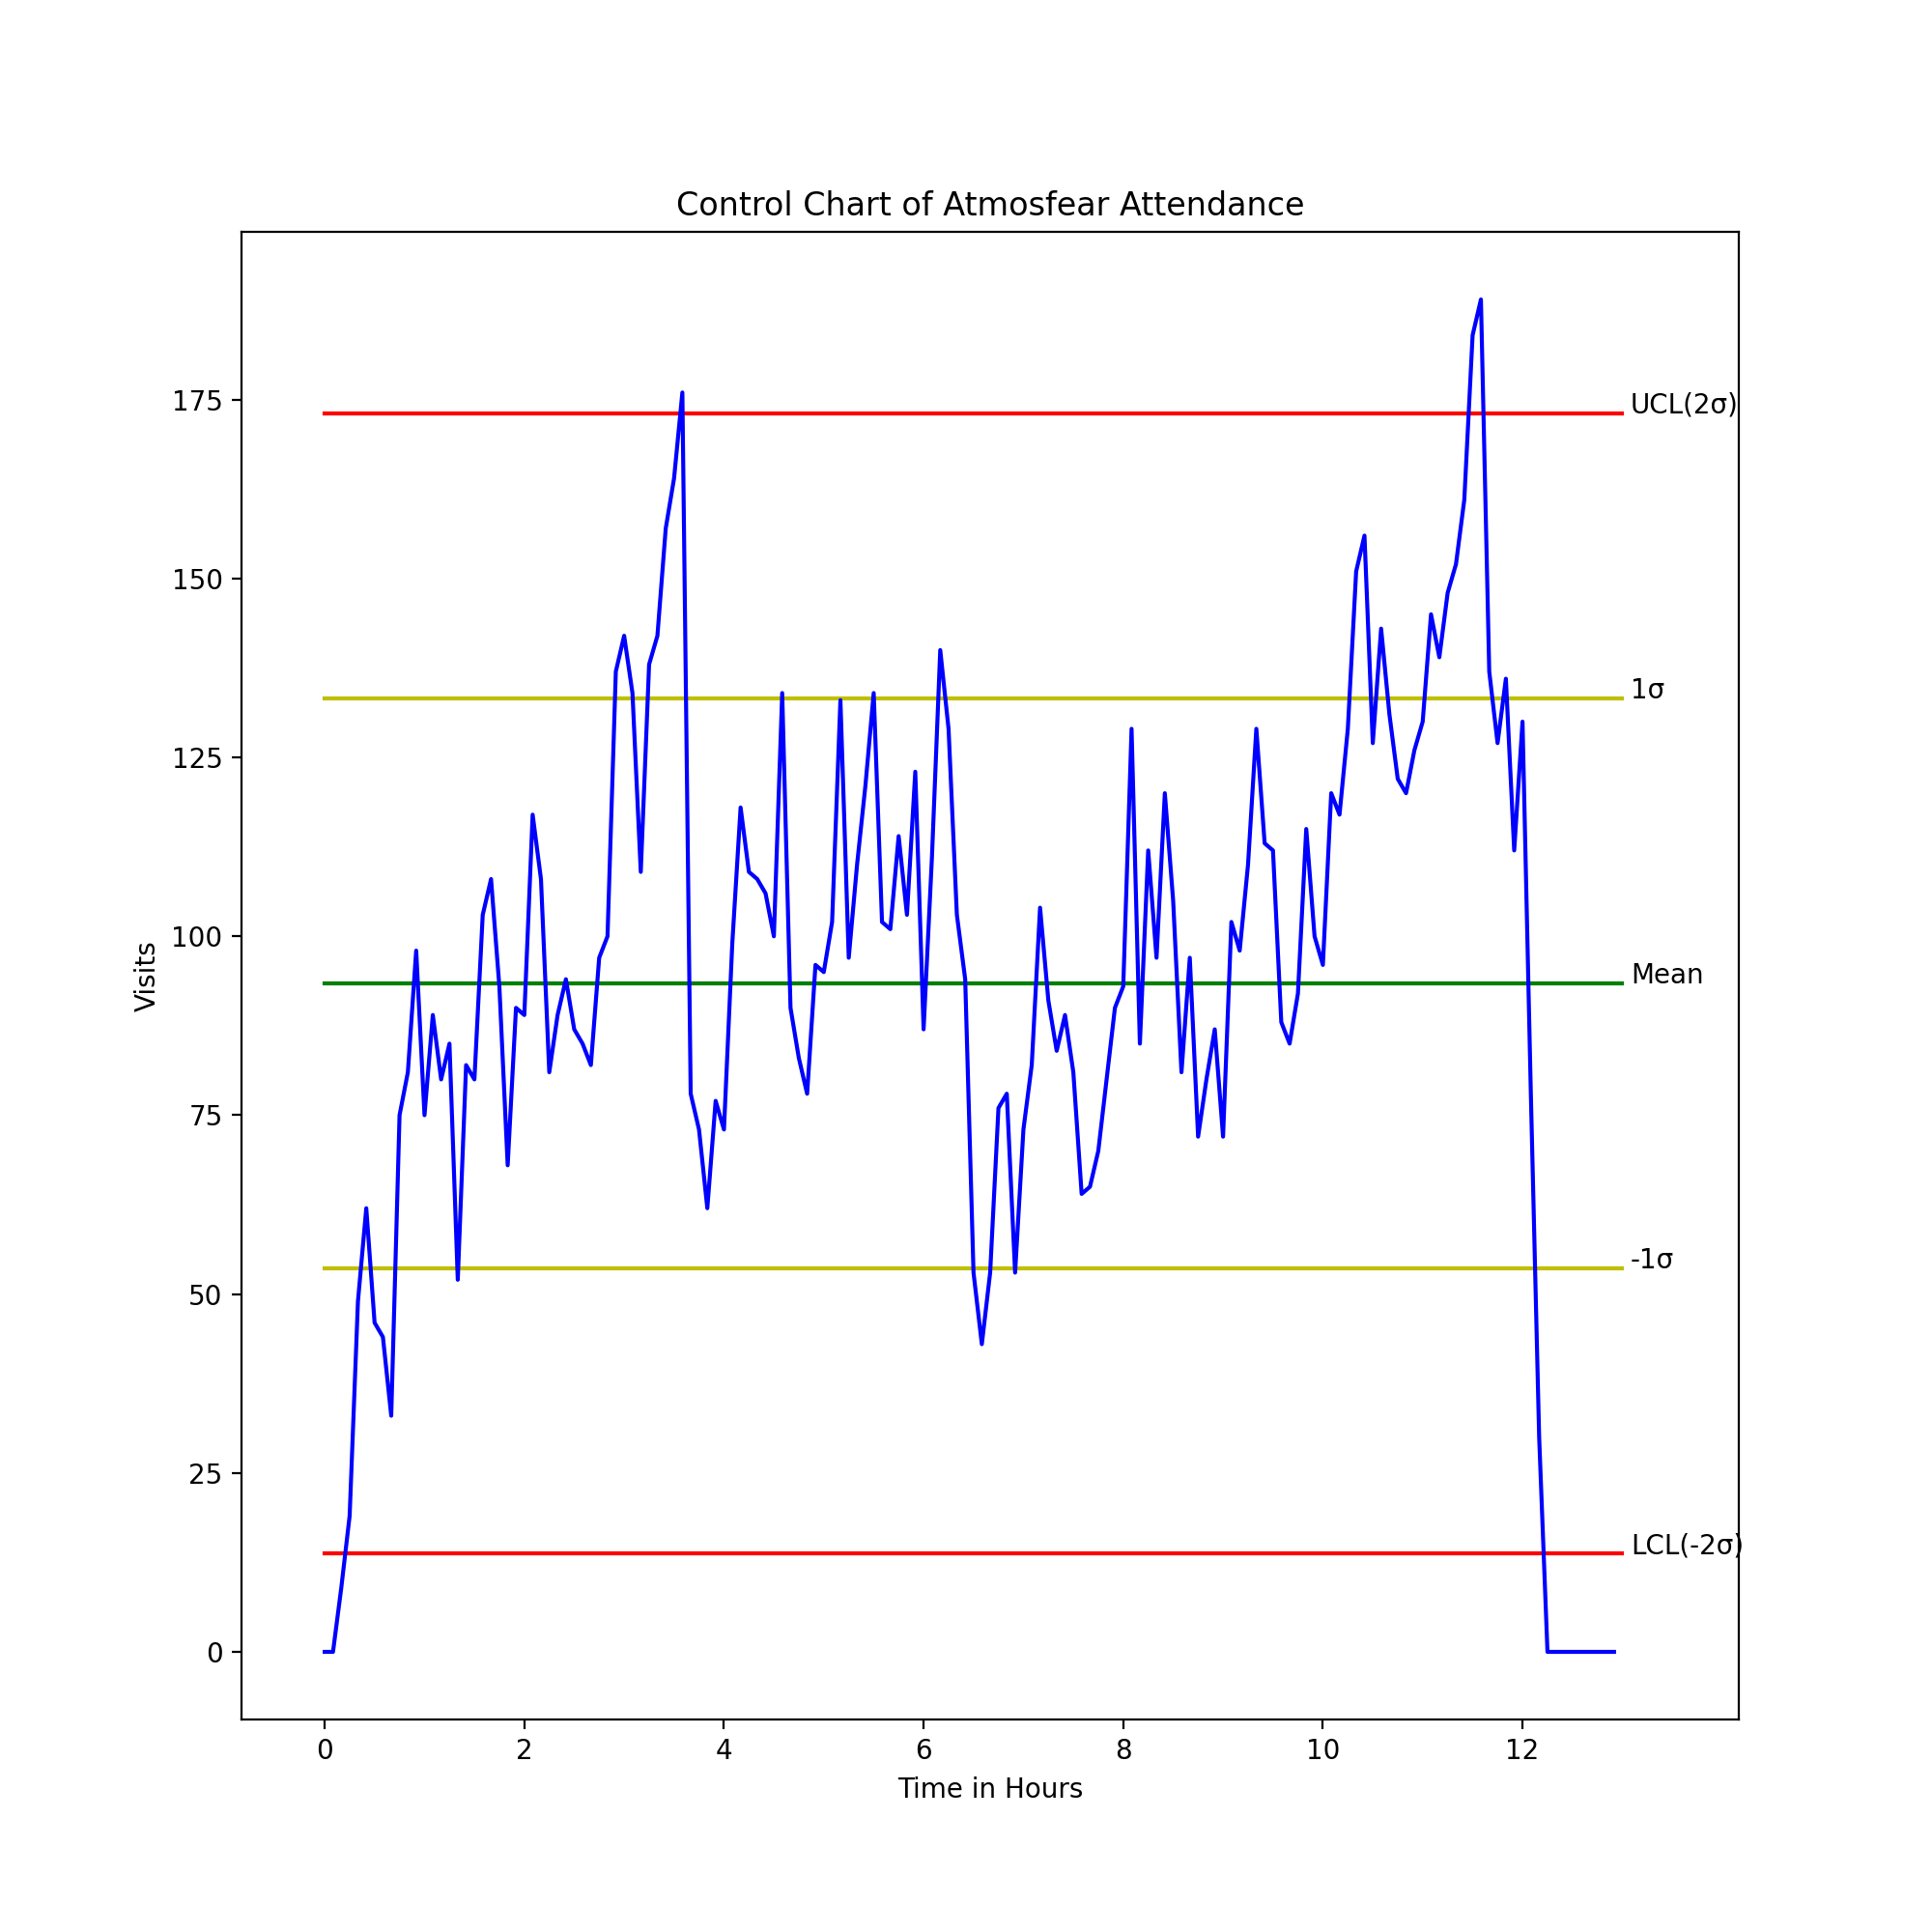

In [14]:
# 1
# Create and display a control chart showing attendance at the ride 'Atmosfear' over the data provided. In the control
# chart, display the attendance, the mean attendance, and bands for one and two standard deviations away from the average.

conn = sqlite3.connect('dinofunworld.db')
cur = conn.cursor()

# Get Atmosfear id
cur.execute('''SELECT attractionid FROM attraction WHERE name = 'Atmosfear';''')
atmosfear_id = cur.fetchone()[0]

cur.execute('''SELECT sequence FROM sequences;''')
sequences = cur.fetchall()


df = pd.DataFrame.from_records(sequences)
df = df[0].str.split('-', expand=True)[range(192)]

visits = (df == str(atmosfear_id)).sum()[:156]
mean = np.mean(visits)
std = np.std(visits)
total_visits = len(visits)

%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
plt.plot([0, len(visits)], [mean, mean], 'g-')
plt.text(total_visits + 1, mean, 'Mean')
plt.plot([0, len(visits)], [mean + std, mean + std], 'y-')
plt.text(total_visits + 1, mean + std, '1' + chr(0x03c3))
plt.plot([0, len(visits)], [mean - std, mean - std], 'y-')
plt.text(total_visits + 1, mean - std, '-1' + chr(0x03c3))
plt.plot([0, len(visits)], [mean + 2 * std, mean + 2 *std], 'r-')
plt.text(total_visits + 1, mean + 2 * std, f"UCL(2{chr(0x03c3)})")
plt.plot([0, len(visits)], [mean - 2 * std, mean - 2 *std], 'r-')
plt.text(total_visits + 1, mean - 2 * std, f"LCL(-2{chr(0x03c3)})")
plt.plot(range(len(visits)), visits, 'b-')
plt.title('Control Chart of Atmosfear Attendance')
plt.xlabel('Time in Hours')
plt.ylabel('Visits')

plt.xticks(range(0, 157, 24))
ax = plt.gca().xaxis
ax.set_ticklabels(range(0, 14, 2))
plt.xlim(-10,170)

# window_size = 50

plt.show()

<IPython.core.display.Javascript object>


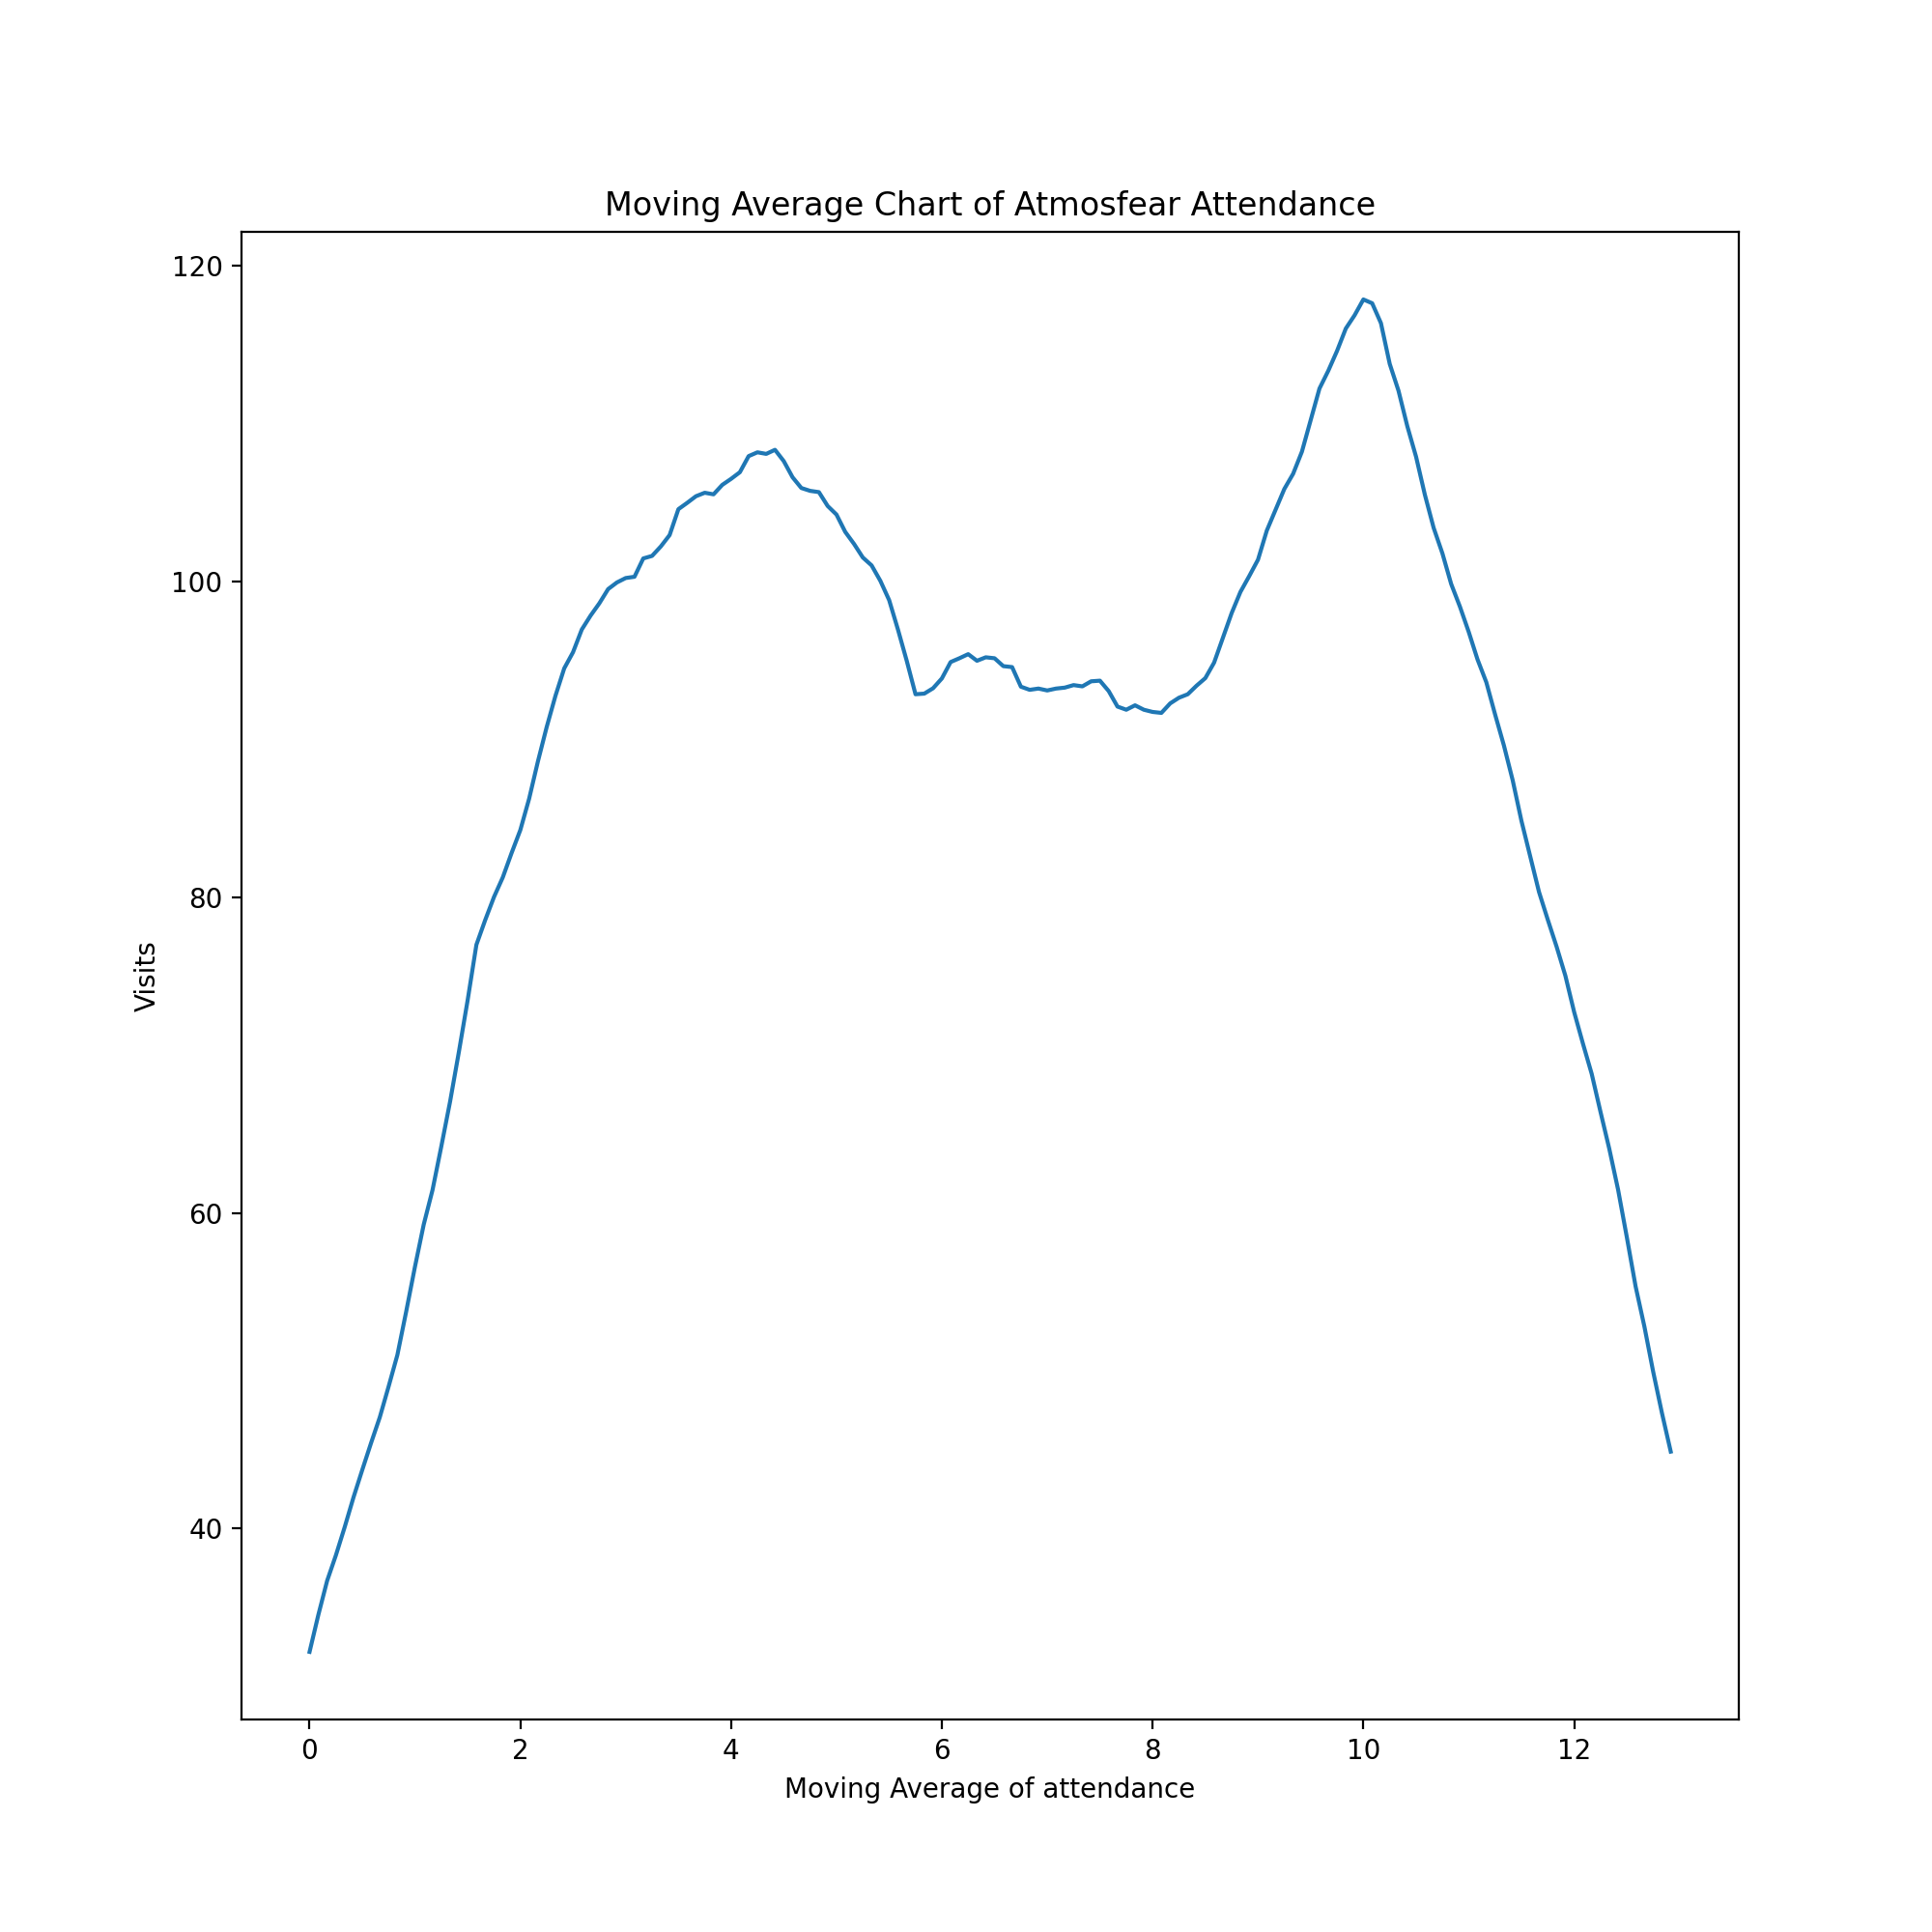

In [18]:
# 2
# Create and display a moving average chart of the attendance at 'Atmosfear' over the data provided. Use a window size of
# 50 for this moving average.

window_size = 50

fig = plt.figure(figsize=(10, 10))
plt.plot(np.convolve(visits, np.ones(window_size, )/window_size, 'same'))

plt.xticks(range(0, 157, 24))
ax = plt.gca().xaxis
ax.set_ticklabels(range(0, 14, 2))

plt.title('Moving Average Chart of Atmosfear Attendance')
plt.xlabel('Moving Average of attendance')
plt.ylabel('Visits')
plt.show()

<IPython.core.display.Javascript object>


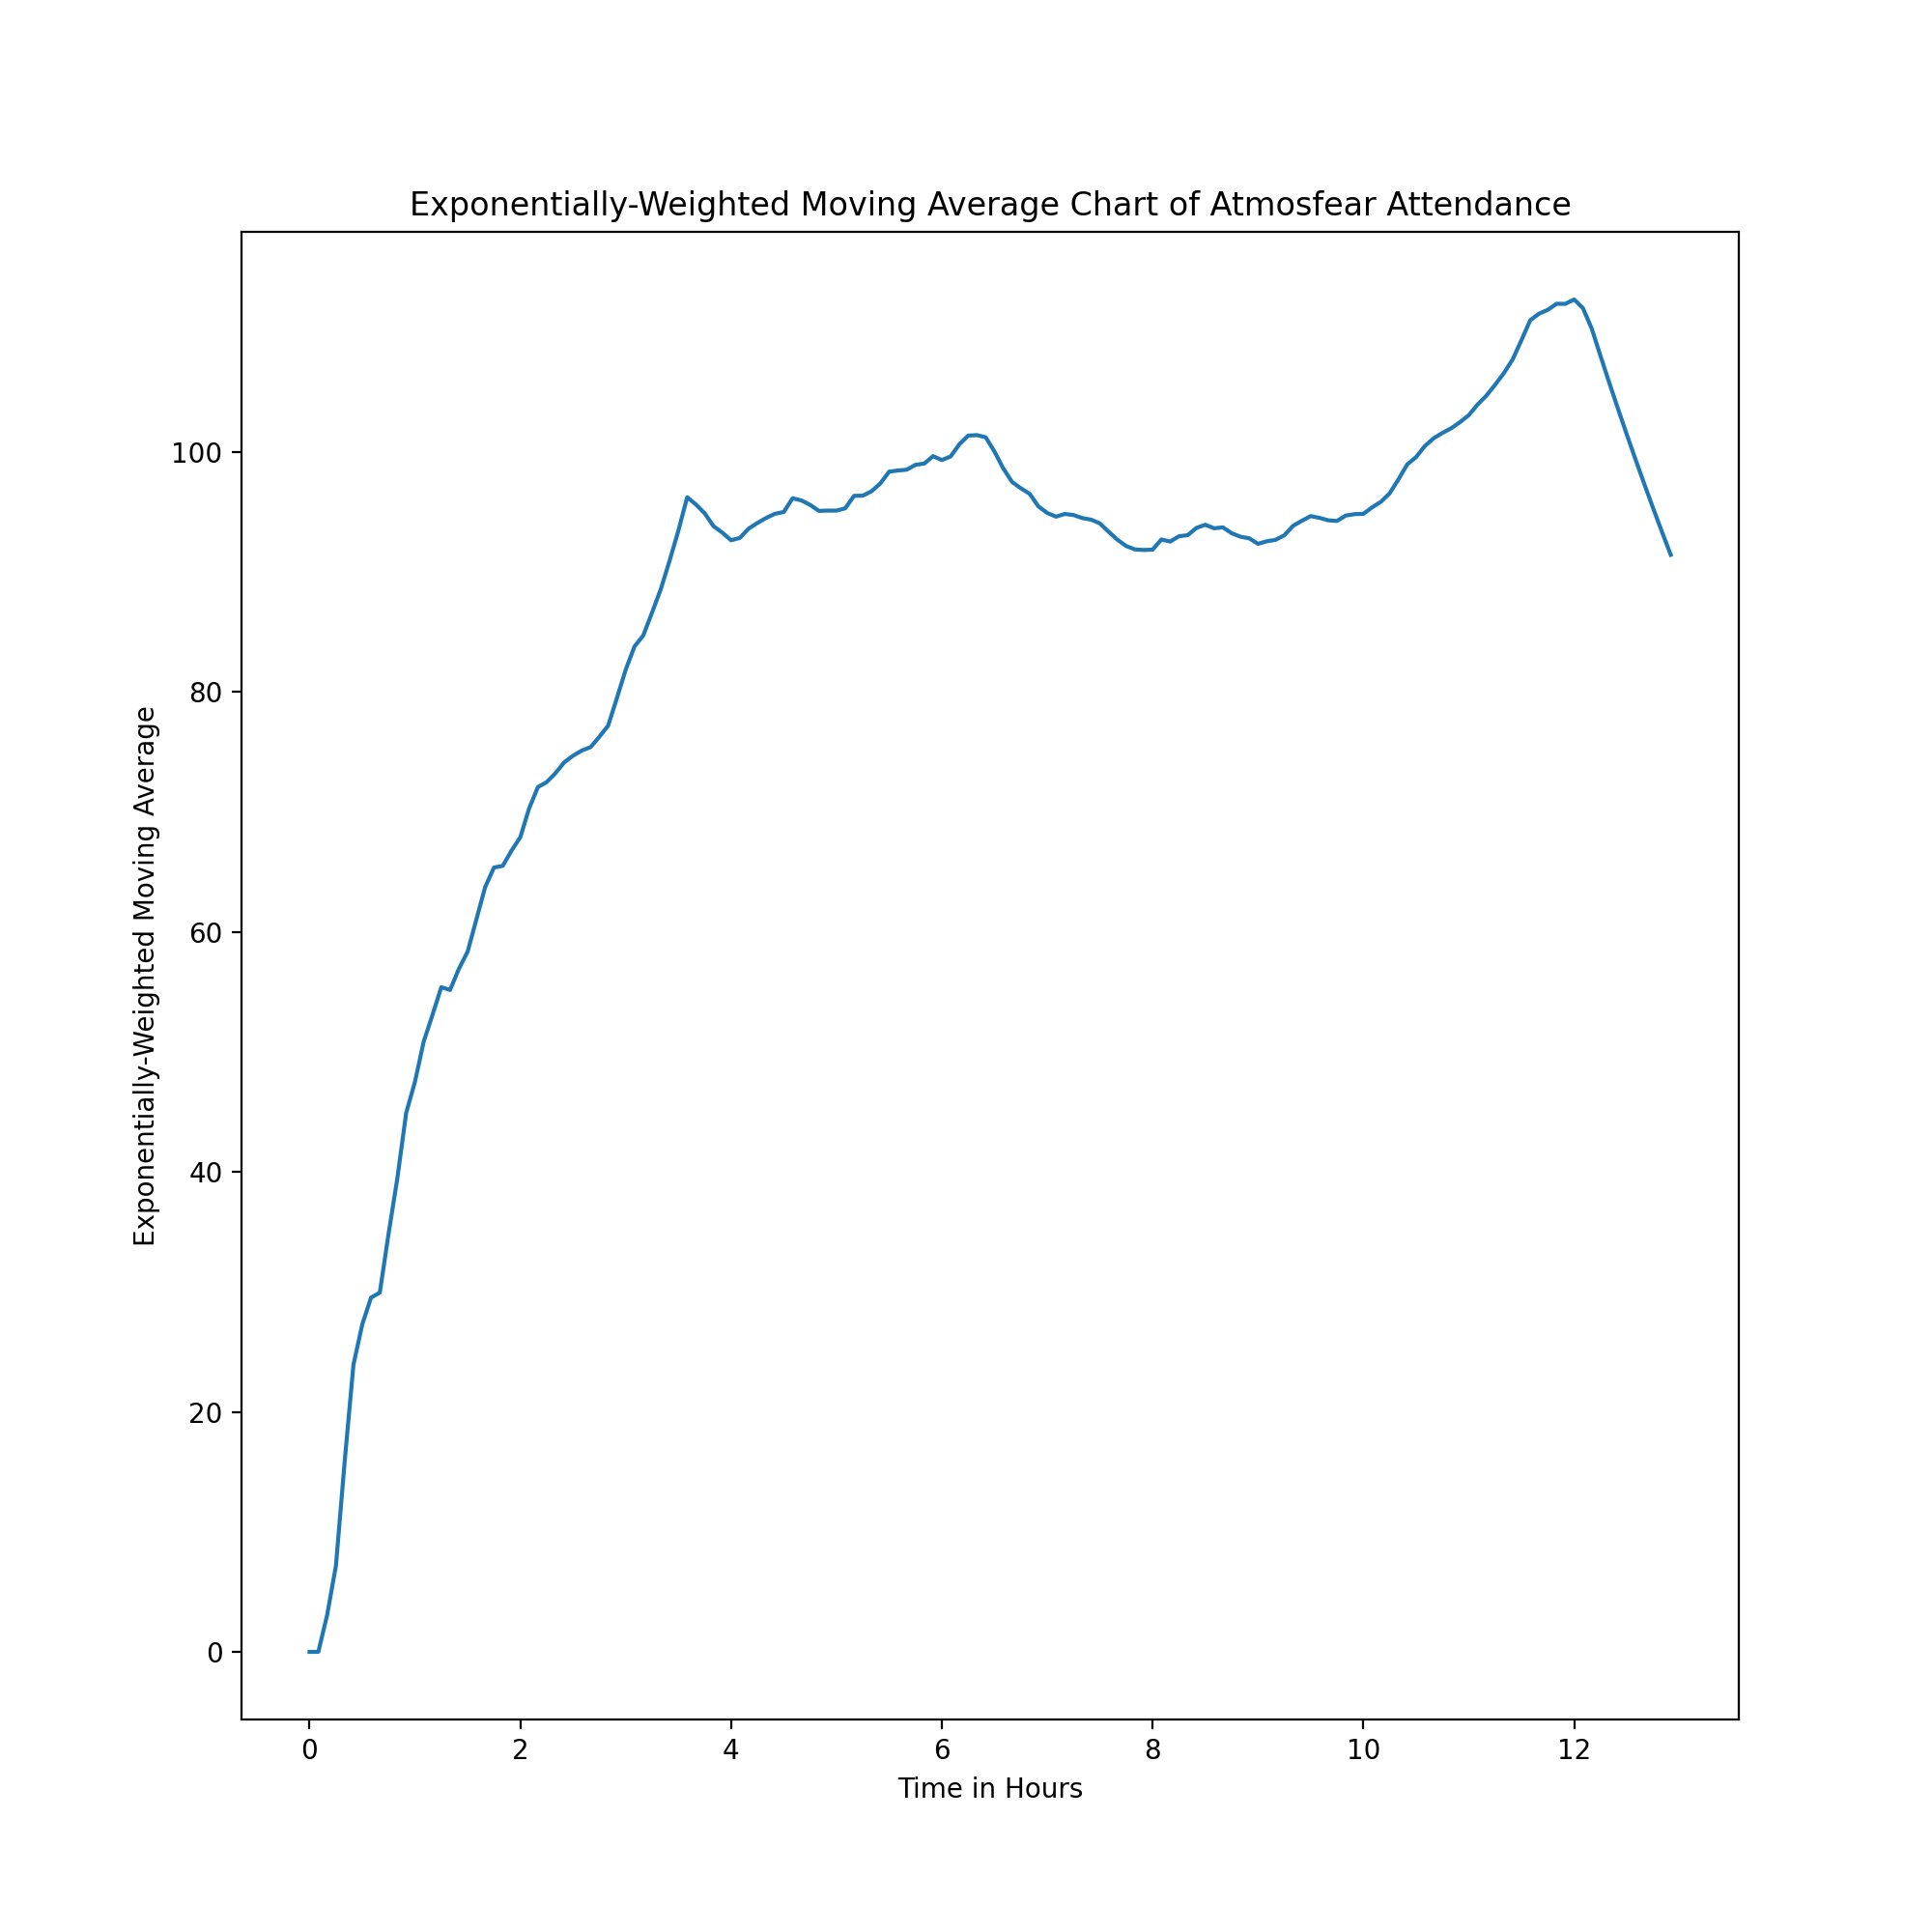

In [20]:
# 3
# Create and display an exponentially-weighted moving average chart of the attendance at 'Atmosfear' over the data provided.
# Again, use a window size of 50 for this weighted moving average.
span = 50
df = pd.DataFrame({'visits': visits})
df_exp = df.ewm(span).mean()

fig = plt.figure(figsize=(10, 10))

plt.xticks(range(0, 157, 24))
ax = plt.gca().xaxis
ax.set_ticklabels(range(0, 14, 2))

plt.title('Exponentially-Weighted Moving Average Chart of Atmosfear Attendance')
plt.xlabel('Time in Hours')
plt.ylabel('Exponentially-Weighted Moving Average')
plt.plot(df_exp)
plt.show()

# Part 5: Hierarchical Clustering

### Assignment Description

As in your previous assignments, the administrators of the Dino Fun World theme park have asked you, one of their data analysts, to perform a data analysis task in order to help them administer the park. In this case, your task builds upon one of the tasks the administrators previously asked you to perform. In a prior task, you were asked to find the distance between a set of visitor trajectories using a simple edit distance algorithm and report the distances. For this task, you must construct and display a dendrogram of those distances. Again, the administrators of the park have provided a database which contains the information needed.

This assignment consists of only one task, which is to generate a dendrogram. Create this dendrogram using the trajectories of the visitors with the IDs: 165316, 1835254, 296394, 404385, and 448990. When performing clustering over the trajectories to inform the dendrogram, use an average distance over all points in the cluster.

<IPython.core.display.Javascript object>


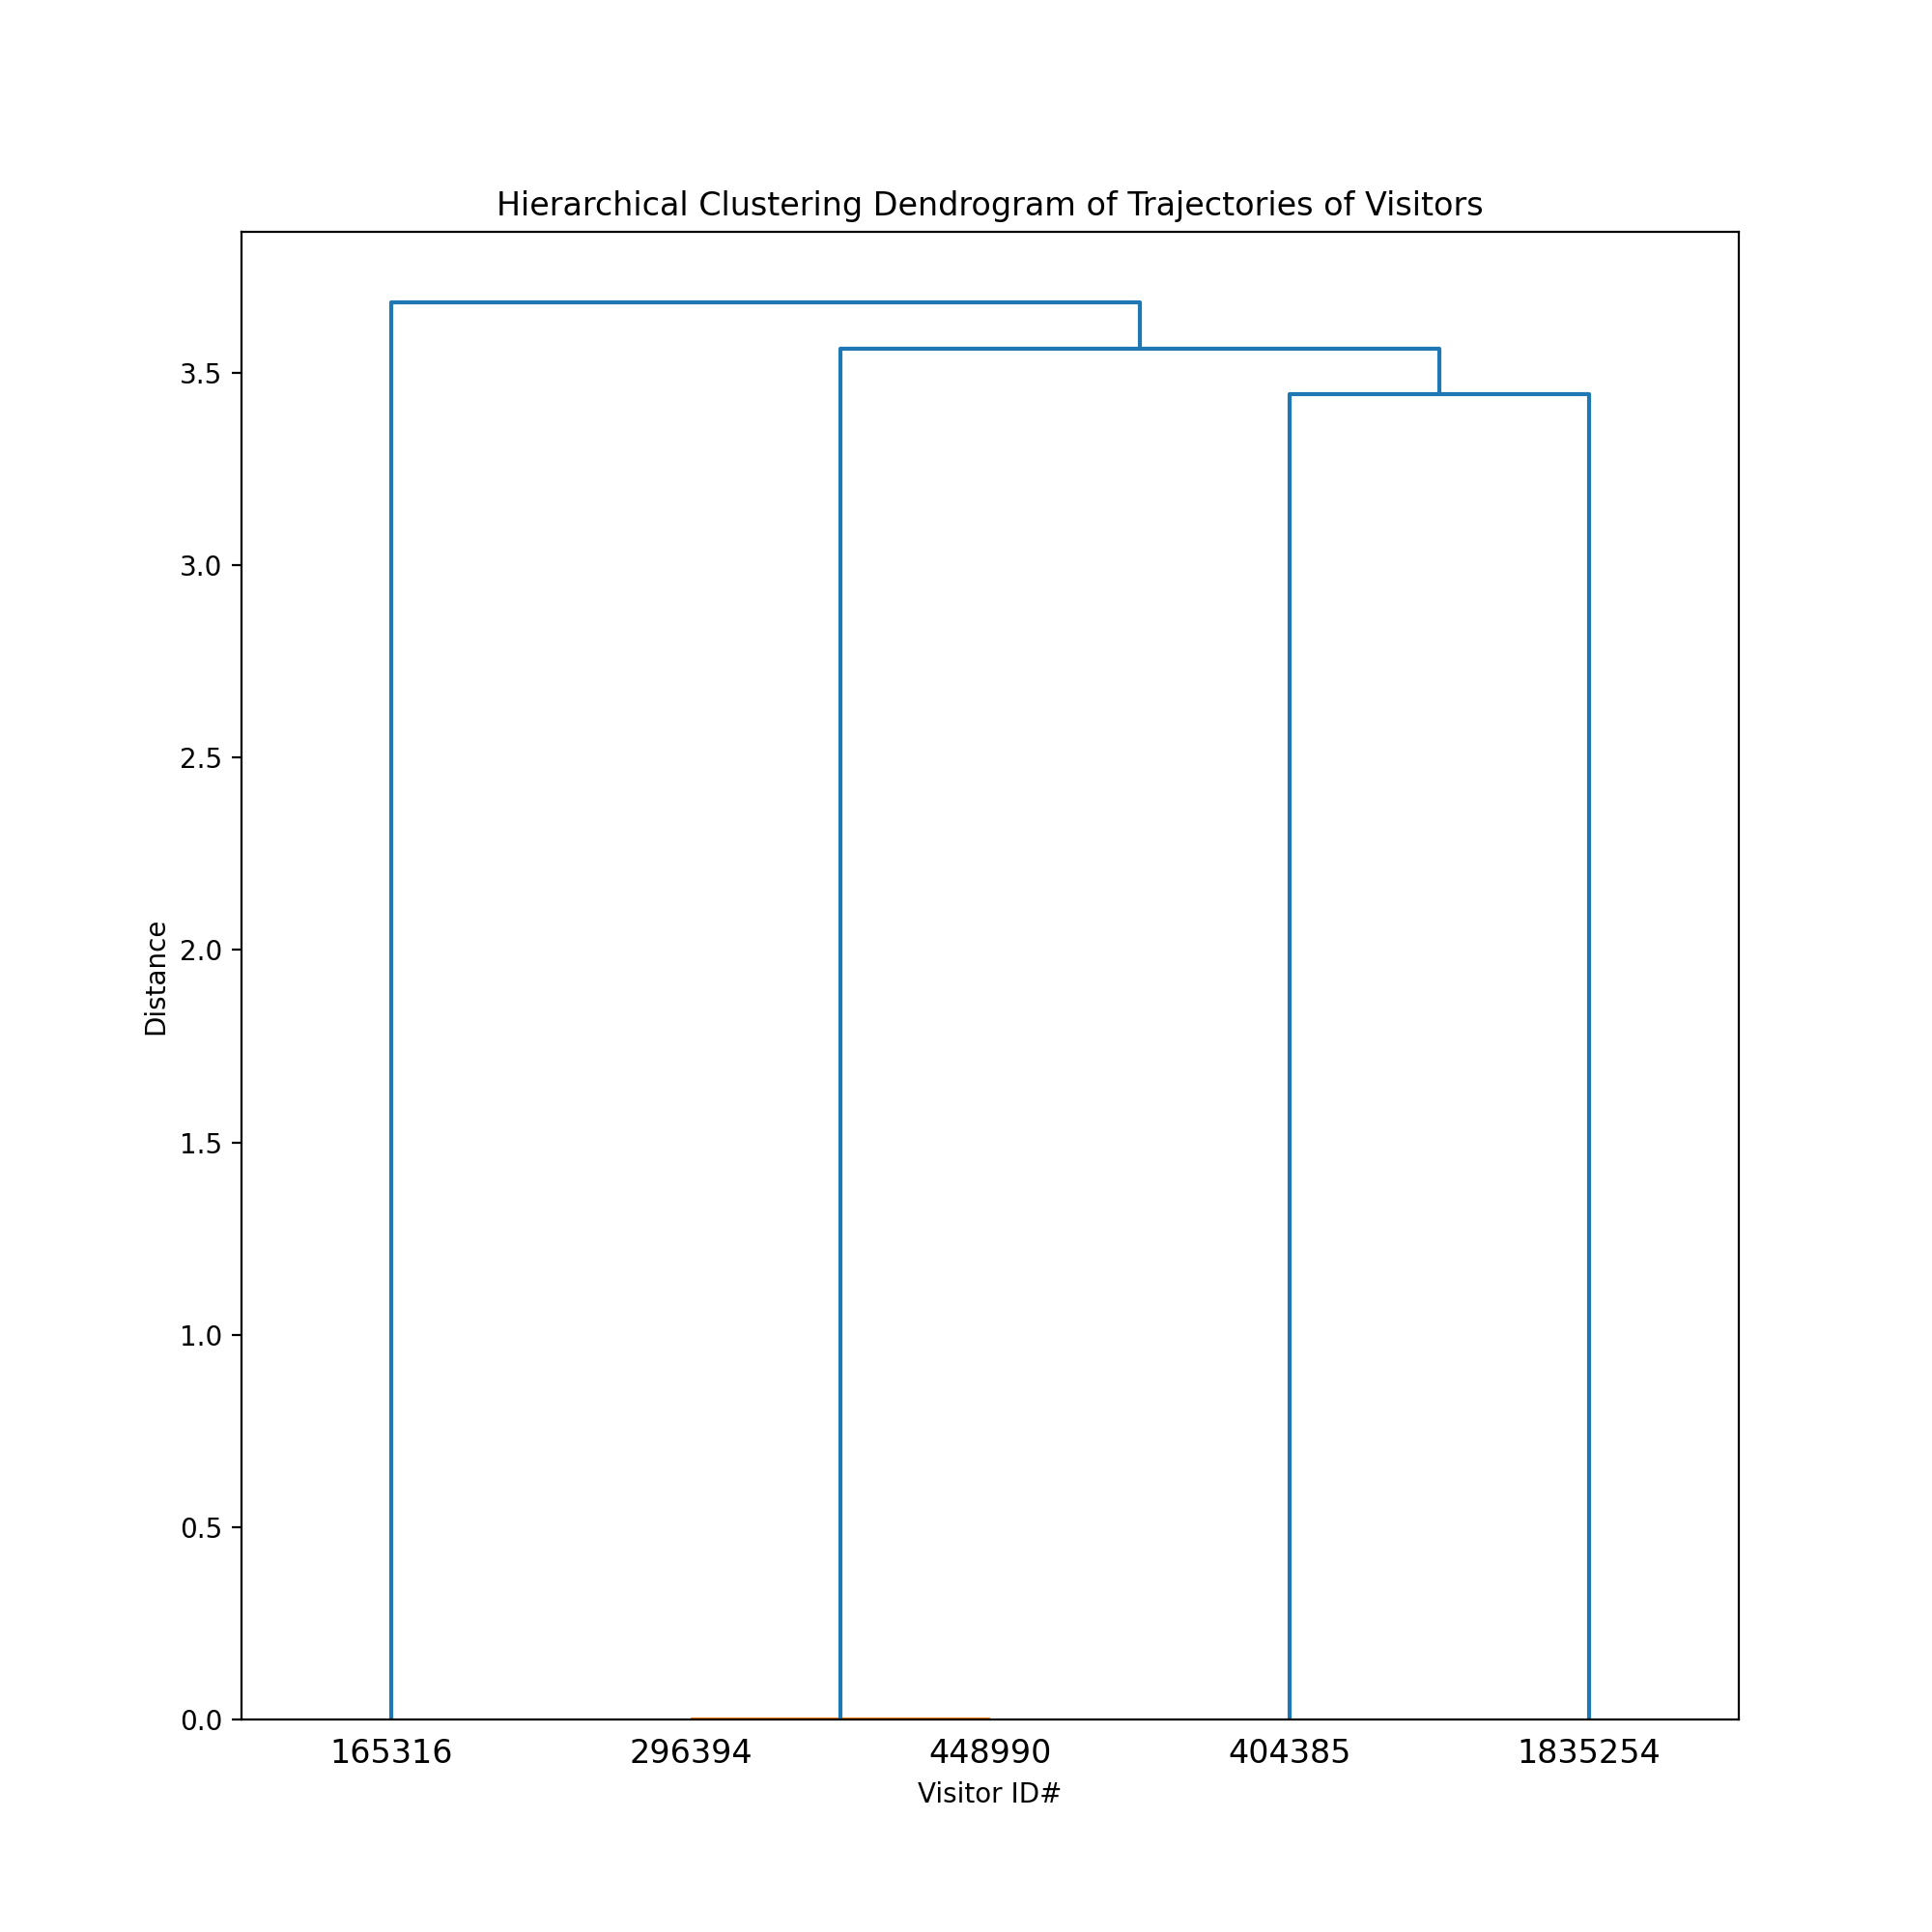

In [21]:
# 1
# Create and display a dendrogram of the trajectories of the 5 visitors specified above.
# The clustering algorithm used to create the dendrogram should use the average distance
# between points in a cluster.

conn = sqlite3.connect('dinofunworld.db')
cur = conn.cursor()

stm = '''
SELECT visitorid, sequence
FROM sequences
WHERE visitorid in (165316, 1835254, 296394, 404385, 448990)
ORDER BY visitorid;
'''
cur.execute(stm)
sequences = cur.fetchall()

distance_matrix = list()
labels = list(zip(*sequences))[0]

for row in sequences:
    sequence_a = np.array(row[1].split('-'), dtype=int)
    distances = list()
    for col in sequences:
        if row == col:
            distances.append(0)
        else:
            sequence_b = np.array(col[1].split('-'), dtype=int)
            distance = ((sequence_a ^ sequence_b) != 0).sum()
            distances.append(distance)
    distance_matrix.append(distances)

X = whiten(distance_matrix)

links = linkage(X)

fig = plt.figure(figsize=(10,10))
dendrogram(links, labels=labels)
plt.title('Hierarchical Clustering Dendrogram of Trajectories of Visitors')
plt.xlabel('Visitor ID#')
plt.ylabel('Distance')

plt.savefig('dendrogram.png')
plt.show()